# cotton leaf disease dataset [xplainable AI for Cotton Leaf Disease Classification]

In [ ]:
# Paper Link: https://onlinelibrary.wiley.com/doi/10.1002/fsn3.70658

In [ ]:
import tensorflow as tf
import matplotlib.pyplot as plt
import os
from tensorflow.keras import layers
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing import image_dataset_from_directory
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.utils.class_weight import compute_class_weight
from google.colab import drive
from tensorflow.keras.callbacks import ReduceLROnPlateau
import numpy as np

In [ ]:
# Mount Google Drive
drive.mount('/content/drive')

# Dataset path and parameters
dataset_path = "/content/drive/MyDrive/CLDD_Dataset/cotton leaf disease dataset [xplainable AI for Cotton Leaf Disease Classification]"
train_path = f'{dataset_path}/train'
test_path = f'{dataset_path}/test'
img_height, img_width = 224, 224
batch_size = 32
class_names = ['Aphids', 'Army worm', 'Bacterial Blight', 'Healthy', 'Powdery Mildew', 'Target spot']

Mounted at /content/drive


In [ ]:
# Load train dataset
train_data = image_dataset_from_directory(
    train_path,
    image_size=(img_height, img_width),
    crop_to_aspect_ratio=True,
    batch_size=batch_size,
    label_mode='categorical'
)

# Load validation data
val_data = image_dataset_from_directory(
    test_path,
    image_size=(img_height, img_width),
    crop_to_aspect_ratio=True,
    batch_size=batch_size,
    label_mode='categorical'
)

print("Classes found in train:", os.listdir(train_path))
print("Class names in train_data:", train_data.class_names)
print("Classes found in test:", os.listdir(test_path))
print("Class names in val_data:", val_data.class_names)

Found 2400 files belonging to 6 classes.
Found 237 files belonging to 6 classes.
Classes found in train: ['Powdery Mildew', 'Target spot', 'Healthy', 'Bacterial Blight', 'Aphids', 'Army worm']
Class names in train_data: ['Aphids', 'Army worm', 'Bacterial Blight', 'Healthy', 'Powdery Mildew', 'Target spot']
Classes found in test: ['Healthy leaf', 'Powdery Mildew', 'Bacterial Blight', 'Target spot', 'Army worm', 'Aphids']
Class names in val_data: ['Aphids', 'Army worm', 'Bacterial Blight', 'Healthy leaf', 'Powdery Mildew', 'Target spot']


In [ ]:
# Function to count samples per class
def count_samples_per_class(dataset):
    class_counts = {name: 0 for name in class_names}
    for _, labels in dataset:
        labels = tf.argmax(labels, axis=1).numpy()
        for label in labels:
            class_counts[class_names[label]] += 1
    return class_counts

# Function to show images
def show_images(dataset, max_row=2, max_col=5):
    plt.figure(figsize=(20, 10))
    for images, labels in dataset.take(1):
        for i in range(min(max_row * max_col, len(images))):
            r, c = i // max_col, i % max_col
            ax = plt.subplot(max_row, max_col, i + 1)
            ax.imshow(images[i].numpy().astype('uint8'))
            ax.set_title(class_names[np.argmax(labels[i])])
            ax.axis('off')
    plt.show()

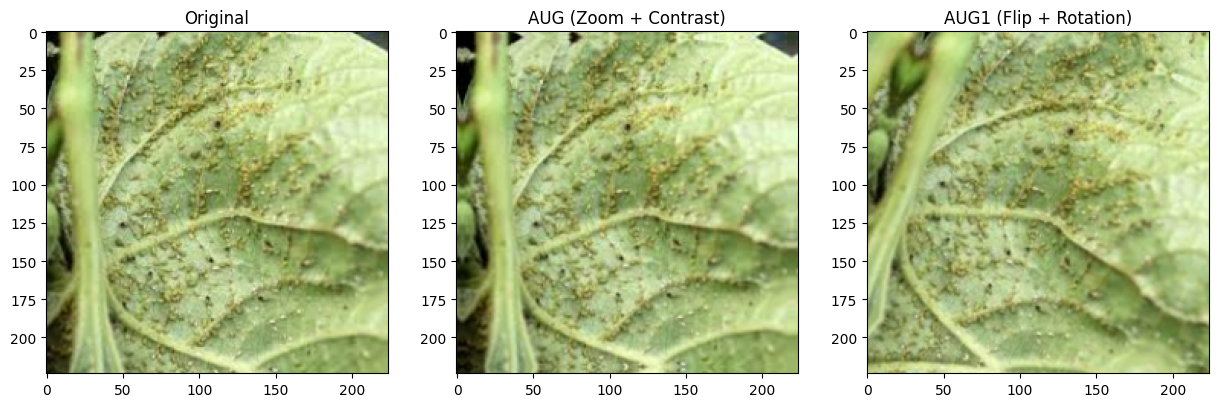

In [ ]:
# Augmentation pipelines
AUG = tf.keras.Sequential([
    layers.RandomZoom(0.1),
    layers.RandomContrast(0.15),
])

AUG1 = tf.keras.Sequential([
    layers.RandomFlip("horizontal"),
    layers.RandomRotation(0.1),
])

# Visualize original and augmented images
def visualize_augmentation(dataset):
    _, axs = plt.subplots(1, 3, figsize=(15, 5))
    for images, labels in dataset.take(1):
        img = images[0]
        axs[0].imshow(img.numpy().astype('uint8'))
        axs[0].set_title("Original")
        axs[1].imshow(AUG(img, training=True).numpy().astype('uint8'))
        axs[1].set_title("AUG (Zoom + Contrast)")
        axs[2].imshow(AUG1(img, training=True).numpy().astype('uint8'))
        axs[2].set_title("AUG1 (Flip + Rotation)")
        plt.show()

visualize_augmentation(train_data)

In [ ]:
# Augmentation function
def augment_data(dataset):
    augmented_images = []
    augmented_labels = []
    for images, labels in dataset:
        for idx in range(len(images)):
            image = images[idx]
            label = labels[idx]
            aug_img = AUG(image, training=True)
            aug_img1 = AUG1(image, training=True)
            augmented_images.extend([image, aug_img, aug_img1])
            augmented_labels.extend([label, label, label])
    return augmented_images, augmented_labels


augmented_images, augmented_labels = augment_data(train_data)
training_aug_data = tf.data.Dataset.from_tensor_slices((augmented_images, augmented_labels))
training_aug_data = training_aug_data.shuffle(1000).batch(batch_size).prefetch(tf.data.AUTOTUNE)

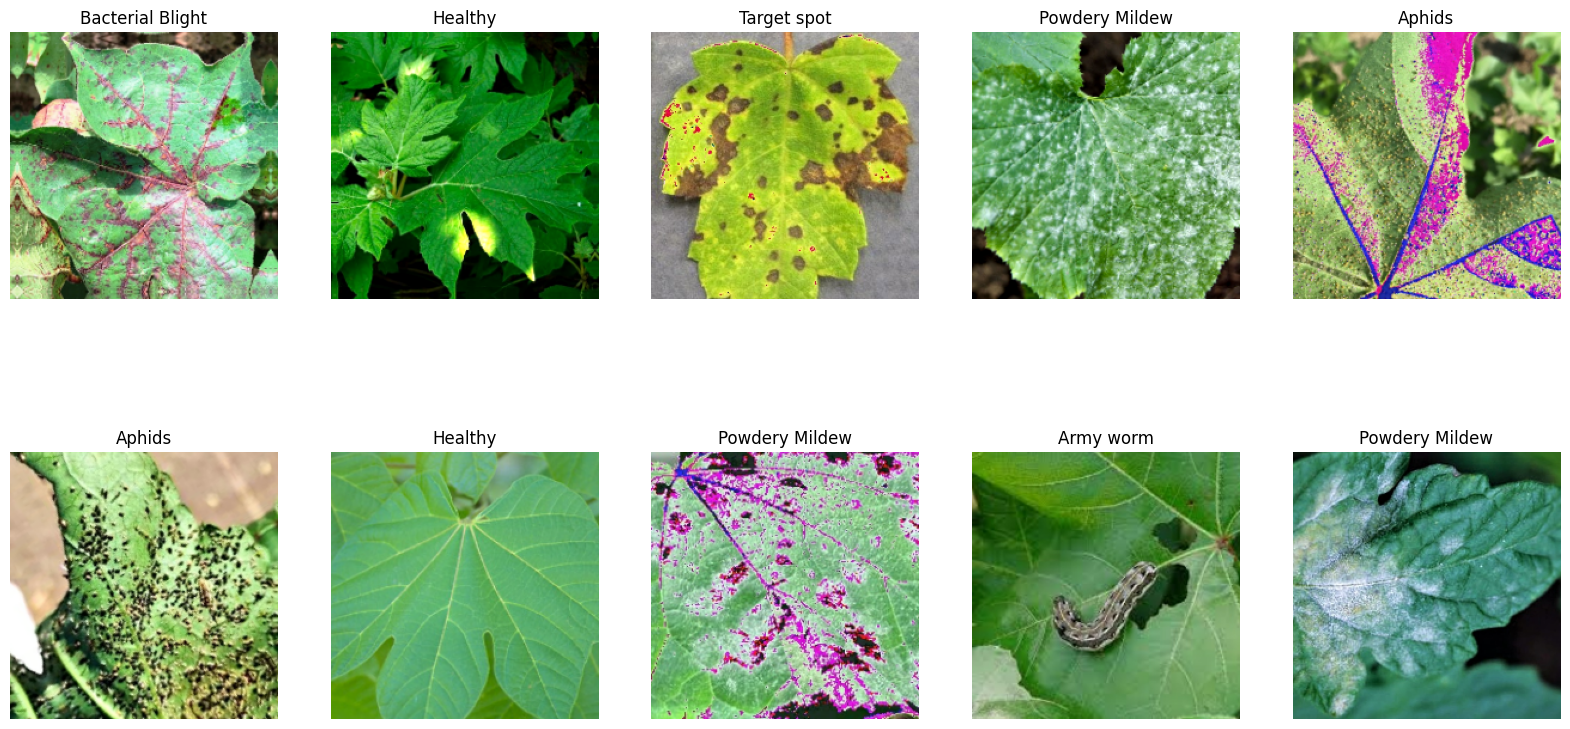

Original train data class counts: {'Aphids': 400, 'Army worm': 400, 'Bacterial Blight': 400, 'Healthy': 400, 'Powdery Mildew': 400, 'Target spot': 400}
Augmented train data class counts: {'Aphids': 1200, 'Army worm': 1200, 'Bacterial Blight': 1200, 'Healthy': 1200, 'Powdery Mildew': 1200, 'Target spot': 1200}


In [ ]:
show_images(training_aug_data)

# Verify class distribution
print(f"Original train data class counts: {count_samples_per_class(train_data)}")
print(f"Augmented train data class counts: {count_samples_per_class(training_aug_data)}")

In [ ]:
# Preprocess input for ResNet50
def preprocess_input(image, label):
    image = tf.keras.applications.resnet50.preprocess_input(image)
    return image, label

training_aug_data = training_aug_data.map(preprocess_input, num_parallel_calls=tf.data.AUTOTUNE)
val_data = val_data.map(preprocess_input, num_parallel_calls=tf.data.AUTOTUNE)

In [ ]:
# Load ResNet50 model
base_model = tf.keras.applications.ResNet50(
    weights='imagenet',
    include_top=False,
    input_shape=(img_height, img_width, 3)
)

94765736/94765736 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


In [ ]:
# Freeze base layers
for layer in base_model.layers:
    layer.trainable = False

# Add custom head
x = tf.keras.layers.GlobalAveragePooling2D()(base_model.output)
x = tf.keras.layers.Dense(512, activation='relu')(x)
x = tf.keras.layers.Dropout(0.4)(x)
output = tf.keras.layers.Dense(len(class_names), activation='softmax')(x)

# Final model
model = Model(inputs=base_model.input, outputs=output)

# Compile model
model.compile(
    optimizer=Adam(learning_rate=0.001),
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

model.summary()

Model: "functional_2"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_2       │ (None, 224, 224,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_pad           │ (None, 230, 230,  │          0 │ input_layer_2[0]… │
│ (ZeroPadding2D)     │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_conv (Conv2D) │ (None, 112, 112,  │      9,472 │ conv1_pad[0][0]   │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_bn            │ (None, 112, 112,  │        256 │ conv1_conv[0][0]  │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_relu          │ (None, 112, 112,  │          0 │ conv1_bn[0][0]    │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ pool1_pad           │ (None, 114, 114,  │          0 │ conv1_relu[0][0]  │
│ (ZeroPadding2D)     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ pool1_pool          │ (None, 56, 56,    │          0 │ pool1_pad[0][0]   │
│ (MaxPooling2D)      │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_conv │ (None, 56, 56,    │      4,160 │ pool1_pool[0][0]  │
│ (Conv2D)            │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_bn   │ (None, 56, 56,    │        256 │ conv2_block1_1_c… │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_relu │ (None, 56, 56,    │          0 │ conv2_block1_1_b… │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_2_conv │ (None, 56, 56,    │     36,928 │ conv2_block1_1_r… │
│ (Conv2D)            │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_2_bn   │ (None, 56, 56,    │        256 │ conv2_block1_2_c… │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_2_relu │ (None, 56, 56,    │          0 │ conv2_block1_2_b… │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_0_conv │ (None, 56, 56,    │     16,640 │ pool1_pool[0][0]  │
│ (Conv2D)            │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_3_conv │ (None, 56, 56,    │     16,640 │ conv2_block1_2_r… │
│ (Conv2D)            │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_0_bn   │ (None, 56, 56,    │      1,024 │ conv2_block1_0_c… │
│ (BatchNormalizatio… │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_3_bn   │ (None, 56, 56,    │      1,024 │ conv2_block1_3_c

 Total params: 24,639,878 (93.99 MB)

 Trainable params: 1,052,166 (4.01 MB)

 Non-trainable params: 23,587,712 (89.98 MB)

In [ ]:
# Stage 1: Train top layers
history = model.fit(
    training_aug_data,
    validation_data=val_data,
    epochs=10,
    verbose=1,
)

Epoch 1/10
225/225 ━━━━━━━━━━━━━━━━━━━━ 94s 332ms/step - accuracy: 0.8679 - loss: 0.4120 - val_accuracy: 0.9916 - val_loss: 0.0135
Epoch 2/10
225/225 ━━━━━━━━━━━━━━━━━━━━ 24s 106ms/step - accuracy: 0.9771 - loss: 0.0635 - val_accuracy: 0.9916 - val_loss: 0.0095
Epoch 3/10
225/225 ━━━━━━━━━━━━━━━━━━━━ 43s 116ms/step - accuracy: 0.9926 - loss: 0.0267 - val_accuracy: 1.0000 - val_loss: 0.0021
Epoch 4/10
225/225 ━━━━━━━━━━━━━━━━━━━━ 39s 106ms/step - accuracy: 0.9918 - loss: 0.0250 - val_accuracy: 1.0000 - val_loss: 0.0023
Epoch 5/10
225/225 ━━━━━━━━━━━━━━━━━━━━ 41s 107ms/step - accuracy: 0.9879 - loss: 0.0338 - val_accuracy: 1.0000 - val_loss: 0.0012
Epoch 6/10
225/225 ━━━━━━━━━━━━━━━━━━━━ 43s 116ms/step - accuracy: 0.9923 - loss: 0.0184 - val_accuracy: 1.0000 - val_loss: 7.0026e-04
Epoch 7/10
225/225 ━━━━━━━━━━━━━━━━━━━━ 39s 108ms/step - accuracy: 0.9932 - loss: 0.0218 - val_accuracy: 1.0000 - val_loss: 1.1390e-04
Epoch 8/10
225/225 ━━━━━━━━━━━━━━━━━━━━ 24s 106ms/step - accuracy: 0.9864 -

In [ ]:
# Stage 2: Fine-tune last 40 layers (exclude BatchNormalization)
for layer in base_model.layers[-40:]:
    if not isinstance(layer, tf.keras.layers.BatchNormalization):
        layer.trainable = True

# Re-compile for fine-tuning
model.compile(
    optimizer=Adam(learning_rate=1e-4),
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

print("Fine-tuning the last 40 layers...")
history_stage2 = model.fit(
    training_aug_data,
    validation_data=val_data,
    epochs=20,
    verbose=1,
)

Fine-tuning the last 40 layers...
Epoch 1/20
225/225 ━━━━━━━━━━━━━━━━━━━━ 59s 181ms/step - accuracy: 0.9849 - loss: 0.0884 - val_accuracy: 0.9958 - val_loss: 0.0071
Epoch 2/20
225/225 ━━━━━━━━━━━━━━━━━━━━ 67s 153ms/step - accuracy: 0.9946 - loss: 0.0164 - val_accuracy: 1.0000 - val_loss: 0.0013
Epoch 3/20
225/225 ━━━━━━━━━━━━━━━━━━━━ 40s 149ms/step - accuracy: 0.9995 - loss: 0.0039 - val_accuracy: 1.0000 - val_loss: 6.3538e-04
Epoch 4/20
225/225 ━━━━━━━━━━━━━━━━━━━━ 41s 149ms/step - accuracy: 0.9988 - loss: 0.0043 - val_accuracy: 1.0000 - val_loss: 3.2984e-04
Epoch 5/20
225/225 ━━━━━━━━━━━━━━━━━━━━ 41s 148ms/step - accuracy: 0.9991 - loss: 0.0059 - val_accuracy: 1.0000 - val_loss: 6.4440e-05
Epoch 6/20
225/225 ━━━━━━━━━━━━━━━━━━━━ 37s 163ms/step - accuracy: 0.9974 - loss: 0.0081 - val_accuracy: 1.0000 - val_loss: 9.7675e-06
Epoch 7/20
225/225 ━━━━━━━━━━━━━━━━━━━━ 38s 151ms/step - accuracy: 1.0000 - loss: 1.8205e-04 - val_accuracy: 1.0000 - val_loss: 1.0121e-05
Epoch 8/20
225/225 ━━━━━━

In [ ]:
# Evaluate model

from sklearn.metrics import classification_report, confusion_matrix
val_results = model.evaluate(val_data)
print(f"Validation loss: {val_results[0]:.4f}, Validation accuracy: {val_results[1]:.4f}")

# Generate classification report and confusion matrix
y_val_true = []
y_val_pred = []
for images, labels in val_data:
    y_val_true.extend(tf.argmax(labels, axis=1).numpy())
    y_val_pred.extend(tf.argmax(model.predict(images), axis=1))

print("Classification Report:")
print(classification_report(y_val_true, y_val_pred, target_names=class_names))

print("Confusion Matrix:")
print(confusion_matrix(y_val_true, y_val_pred))

8/8 ━━━━━━━━━━━━━━━━━━━━ 2s 167ms/step - accuracy: 1.0000 - loss: 1.2894e-06
Validation loss: 0.0000, Validation accuracy: 1.0000
1/1 ━━━━━━━━━━━━━━━━━━━━ 6s 6s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 167ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 140ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 124ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 123ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 116ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 115ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 4s 4s/step
Classification Report:
                  precision    recall  f1-score   support

          Aphids       1.00      1.00      1.00        39
       Army worm       1.00      1.00      1.00        40
Bacterial Blight       1.00      1.00      1.00        40
         Healthy       1.00      1.00      1.00        39
  Powdery Mildew       1.00      1.00      1.00        38
     Target spot       1.00      1.00      1.00        41

        accuracy                           1.00       237
       macro avg       1.00      1.00      1.00       237
    weighted avg 

In [ ]:
# Plot training history
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'] + history_stage2.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'] + history_stage2.history['val_accuracy'], label='Val Accuracy')
plt.title('Accuracy')
plt.legend()
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'] + history_stage2.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'] + history_stage2.history['val_loss'], label='Val Loss')
plt.title('Loss')
plt.legend()
plt.show()

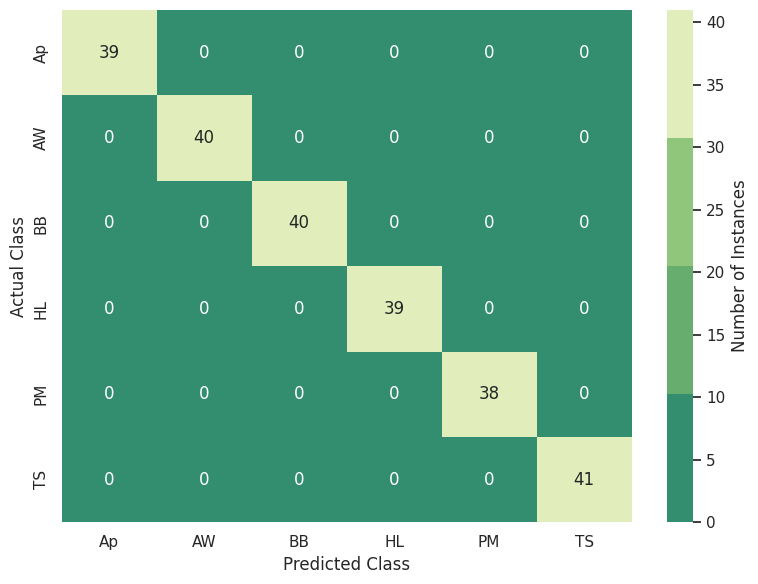

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib.colors import ListedColormap

# Define the confusion matrix
confusion_matrix = np.array([
    [39,  0,  0,  0,  0,  0],
 [ 0, 40,  0,  0,  0,  0],
 [ 0,  0, 40,  0,  0,  0],
 [ 0,  0,  0, 39,  0,  0],
 [ 0,  0,  0,  0, 38,  0],
 [ 0,  0,  0,  0,  0, 41]
])

# Define class names and their abbreviations
class_names = ['Aphids', 'Army worm', 'Bacterial Blight', 'Healthy', 'Powdery Mildew', 'Target spot']
class_abbr = ['Ap', 'AW', 'BB', 'HL', 'PM', 'TS']

# Define custom colors
colors = ['#328E6E', '#67AE6E', '#90C67C', '#E1EEBC']
custom_cmap = ListedColormap(colors)

# Set up the plot
plt.figure(figsize=(8, 6))
sns.set(font_scale=1)  # Increase font size for readability
sns.heatmap(confusion_matrix, annot=True, fmt='d', cmap=custom_cmap,
            xticklabels=class_abbr, yticklabels=class_abbr,
            cbar_kws={'label': 'Number of Instances'})
plt.xlabel('Predicted Class')
plt.ylabel('Actual Class')
# plt.title('Confusion Matrix for Cotton Leaf Disease Classification\n(ResNet50, Dual Augmentation, 40 layers, dropout=0.4)')
plt.tight_layout()

# Display the plot
plt.show()

# Save the figure
plt.savefig('confusion_matrix.png', dpi=300, bbox_inches='tight')
plt.close()

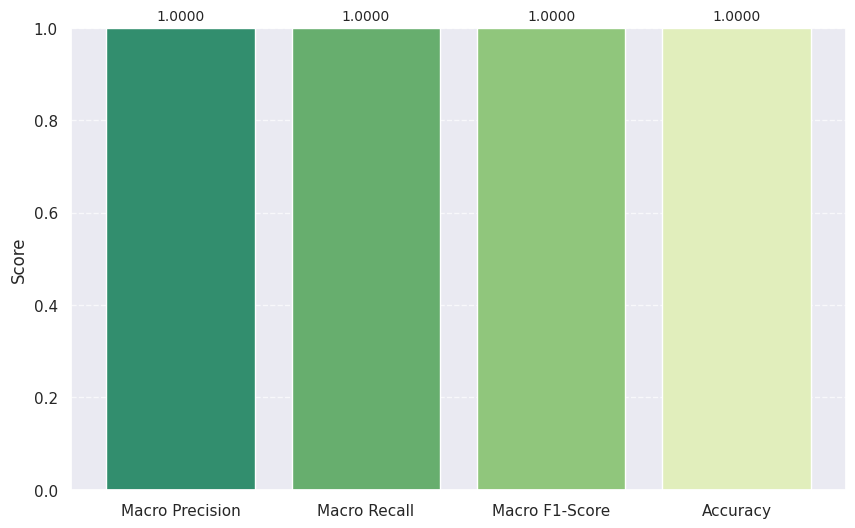

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

def calculate_metrics(confusion_matrix):
    n_classes = confusion_matrix.shape[0]

    # Initialize variables
    TP = np.zeros(n_classes)
    FP = np.zeros(n_classes)
    FN = np.zeros(n_classes)

    # Calculate TP, FP, FN for each class
    for i in range(n_classes):
        TP[i] = confusion_matrix[i, i]
        FP[i] = np.sum(confusion_matrix[:, i]) - TP[i]
        FN[i] = np.sum(confusion_matrix[i, :]) - TP[i]

    # Calculate macro-average precision, recall, f1-score
    precision = []
    recall = []
    for i in range(n_classes):
        prec = TP[i] / (TP[i] + FP[i]) if (TP[i] + FP[i]) > 0 else 0.0
        rec = TP[i] / (TP[i] + FN[i]) if (TP[i] + FN[i]) > 0 else 0.0
        precision.append(prec)
        recall.append(rec)

    macro_precision = np.mean(precision)
    macro_recall = np.mean(recall)
    macro_f1 = 2 * (macro_precision * macro_recall) / (macro_precision + macro_recall) if (macro_precision + macro_recall) > 0 else 0.0

    # Calculate overall accuracy
    total_correct = np.sum(TP)
    total_samples = np.sum(confusion_matrix)
    accuracy = total_correct / total_samples if total_samples > 0 else 0.0

    return macro_precision, macro_recall, macro_f1, accuracy

# Provided confusion matrix
confusion_matrix = np.array([
  [39,  0,  0,  0,  0,  0],
 [ 0, 40,  0,  0,  0,  0],
 [ 0,  0, 40,  0,  0,  0],
 [ 0,  0,  0, 39,  0,  0],
 [ 0,  0,  0,  0, 38,  0],
 [ 0,  0,  0,  0,  0, 41]
])

# Calculate metrics
macro_precision, macro_recall, macro_f1, accuracy = calculate_metrics(confusion_matrix)

# Create bar chart
metrics = ['Macro Precision', 'Macro Recall', 'Macro F1-Score', 'Accuracy']
values = [macro_precision, macro_recall, macro_f1, accuracy]

plt.figure(figsize=(10, 6))
bars = plt.bar(metrics, values, color=['#328E6E', '#67AE6E', '#90C67C', '#E1EEBC'])
plt.ylim(0, 1)
# plt.title('Evaluation Metrics [RandZCRandFR_CI_FT40] from Confusion Matrix', fontsize=13)
plt.ylabel('Score', fontsize=12)
plt.grid(axis='y', linestyle='--', alpha=0.7)

# Add value labels on top of bars
for bar in bars:
    yval = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2, yval + 0.01, f'{yval:.4f}',
             ha='center', va='bottom', fontsize=10)

# plt.savefig('FT40_ResNet50_evaluation_metrics[RandZCRandFR_CI].png')

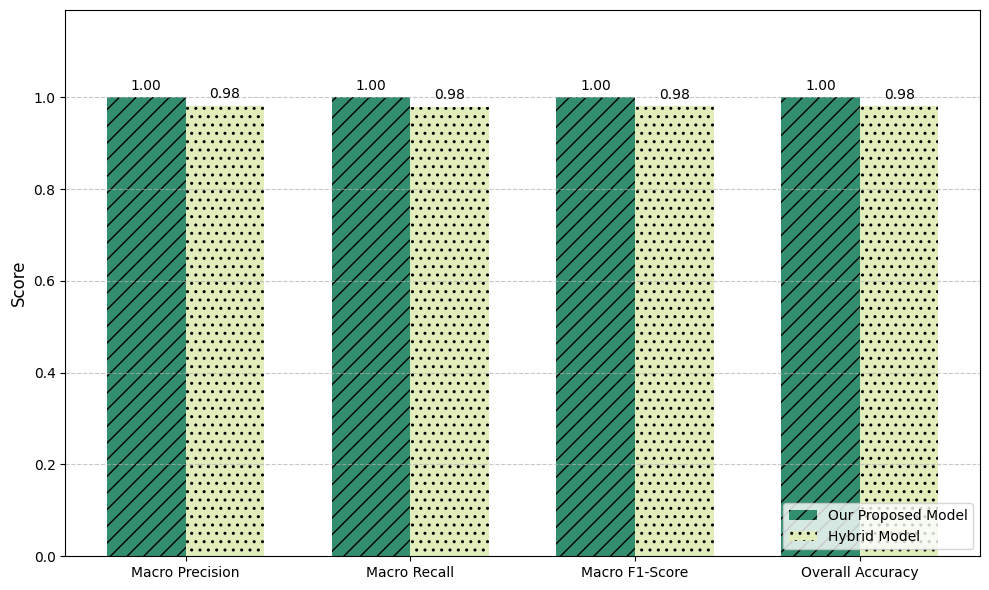

In [1]:
import matplotlib.pyplot as plt
import numpy as np

# Data from your model (macro-average and overall accuracy)
your_model_metrics = {
    'Macro Precision': 1.00,
    'Macro Recall': 1.00,
    'Macro F1-Score': 1.00,
    'Overall Accuracy': 1.00
}

# Data from related paper (Inception V3)
paper_metrics = {
    'Macro Precision': 0.9810,
    'Macro Recall': 0.9790,
    'Macro F1-Score': 0.9800,
    'Overall Accuracy': 0.9800
}

# Metrics to compare
metrics = ['Macro Precision', 'Macro Recall', 'Macro F1-Score', 'Overall Accuracy']

# Set up the plot
plt.figure(figsize=(10, 6))
x = np.arange(len(metrics))
width = 0.35

# Plot bars
plt.bar(x - width/2, [your_model_metrics[m] for m in metrics], width, label='Our Proposed Model', color='#328E6E', hatch='//')
plt.bar(x + width/2, [paper_metrics[m] for m in metrics], width, label='Hybrid Model', color='#E1EEBC', hatch='..')

# Add value labels on top of bars
for i, m in enumerate(metrics):
    plt.text(i - width/2, your_model_metrics[m] + 0.01, f'{your_model_metrics[m]:.2f}',
             ha='center', va='bottom', fontsize=10)
    plt.text(i + width/2, paper_metrics[m] + 0.01, f'{paper_metrics[m]:.2f}',
             ha='center', va='bottom', fontsize=10)

# Customize plot
plt.ylabel('Score', fontsize=12)
# plt.title('Overall Metrics Comparison: Our Model vs. Inception V3', fontsize=14)
plt.xticks(x, metrics, fontsize=10)
plt.ylim(0, 1.19)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.legend(loc='lower right')

# Adjust layout and save
plt.tight_layout()
plt.savefig('overall_metrics_comparison.png')
plt.show()

Using Only Train folders images:

In [ ]:
import tensorflow as tf
import matplotlib.pyplot as plt
import os
from tensorflow.keras import layers
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing import image_dataset_from_directory
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.utils.class_weight import compute_class_weight
from google.colab import drive
from tensorflow.keras.callbacks import ReduceLROnPlateau
import numpy as np

In [ ]:
# Mount Google Drive
drive.mount('/content/drive')

# Dataset path and parameters
dataset_path = "/content/drive/MyDrive/CLDD_Dataset/cotton leaf disease dataset [xplainable AI for Cotton Leaf Disease Classification]/train"
img_height, img_width = 224, 224
batch_size = 32
class_names = ['Aphids', 'Army worm', 'Bacterial Blight', 'Healthy', 'Powdery Mildew', 'Target spot']

Mounted at /content/drive


In [ ]:
# Load dataset
train_data, val_data = image_dataset_from_directory(
    dataset_path,
    validation_split=0.2,
    subset="both",
    seed=42,
    image_size=(img_height, img_width),
    crop_to_aspect_ratio=True,
    batch_size=batch_size,
    label_mode='categorical'
)

print("Classes found:", os.listdir(dataset_path))
print(f"Class names: {train_data.class_names}")

Found 2400 files belonging to 6 classes.
Using 1920 files for training.
Using 480 files for validation.
Classes found: ['Powdery Mildew', 'Target spot', 'Healthy', 'Bacterial Blight', 'Aphids', 'Army worm']
Class names: ['Aphids', 'Army worm', 'Bacterial Blight', 'Healthy', 'Powdery Mildew', 'Target spot']


In [ ]:
# Function to count samples per class
def count_samples_per_class(dataset):
    class_counts = {name: 0 for name in class_names}
    for _, labels in dataset:
        labels = tf.argmax(labels, axis=1).numpy()
        for label in labels:
            class_counts[class_names[label]] += 1
    return class_counts

# Function to show images
def show_images(dataset, max_row=2, max_col=5):
    plt.figure(figsize=(20, 10))
    for images, labels in dataset.take(1):
        for i in range(min(max_row * max_col, len(images))):
            r, c = i // max_col, i % max_col
            ax = plt.subplot(max_row, max_col, i + 1)
            ax.imshow(images[i].numpy().astype('uint8'))
            ax.set_title(class_names[np.argmax(labels[i])])
            ax.axis('off')
    plt.show()

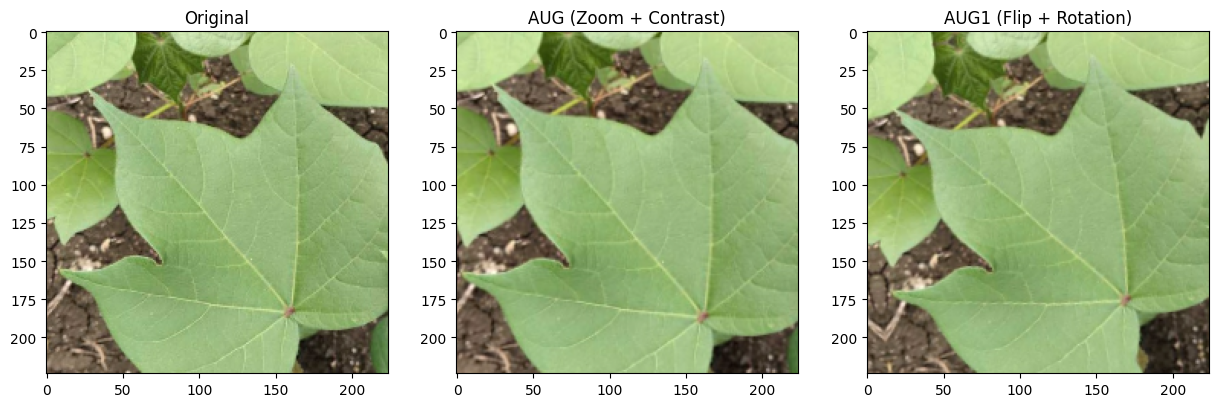

In [ ]:
# Augmentation pipelines
AUG = tf.keras.Sequential([
    layers.RandomZoom(0.1),
    layers.RandomContrast(0.15),
])

AUG1 = tf.keras.Sequential([
    layers.RandomFlip("horizontal"),
    layers.RandomRotation(0.1),
])

# Visualize original and augmented images
def visualize_augmentation(dataset):
    _, axs = plt.subplots(1, 3, figsize=(15, 5))
    for images, labels in dataset.take(1):
        img = images[0]
        axs[0].imshow(img.numpy().astype('uint8'))
        axs[0].set_title("Original")
        axs[1].imshow(AUG(img, training=True).numpy().astype('uint8'))
        axs[1].set_title("AUG (Zoom + Contrast)")
        axs[2].imshow(AUG1(img, training=True).numpy().astype('uint8'))
        axs[2].set_title("AUG1 (Flip + Rotation)")
        plt.show()

visualize_augmentation(train_data)

In [ ]:
# Augmentation function
def augment_data(dataset):
    augmented_images = []
    augmented_labels = []
    for images, labels in dataset:
        for idx in range(len(images)):
            image = images[idx]
            label = labels[idx]
            aug_img = AUG(image, training=True)
            aug_img1 = AUG1(image, training=True)
            augmented_images.extend([image, aug_img, aug_img1])
            augmented_labels.extend([label, label, label])
    return augmented_images, augmented_labels


augmented_images, augmented_labels = augment_data(train_data)
training_aug_data = tf.data.Dataset.from_tensor_slices((augmented_images, augmented_labels))
training_aug_data = training_aug_data.shuffle(1000).batch(batch_size).prefetch(tf.data.AUTOTUNE)

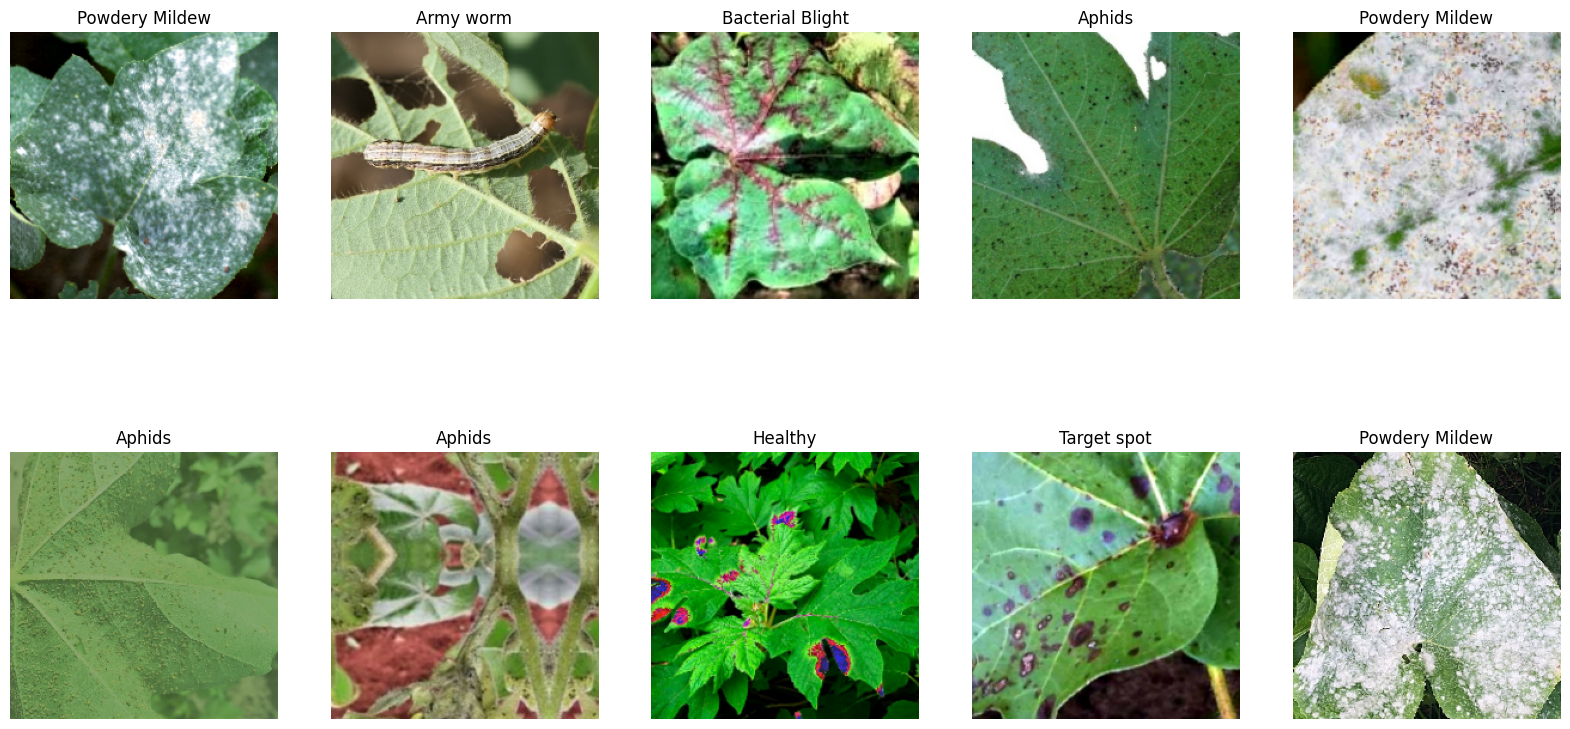

Original train data class counts: {'Aphids': 336, 'Army worm': 315, 'Bacterial Blight': 314, 'Healthy': 327, 'Powdery Mildew': 317, 'Target spot': 311}
Augmented train data class counts: {'Aphids': 1008, 'Army worm': 945, 'Bacterial Blight': 942, 'Healthy': 981, 'Powdery Mildew': 951, 'Target spot': 933}


In [ ]:
show_images(training_aug_data)

# Verify class distribution
print(f"Original train data class counts: {count_samples_per_class(train_data)}")
print(f"Augmented train data class counts: {count_samples_per_class(training_aug_data)}")

In [ ]:
# Preprocess input for ResNet50
def preprocess_input(image, label):
    image = tf.keras.applications.resnet50.preprocess_input(image)
    return image, label

training_aug_data = training_aug_data.map(preprocess_input, num_parallel_calls=tf.data.AUTOTUNE)
val_data = val_data.map(preprocess_input, num_parallel_calls=tf.data.AUTOTUNE)

In [ ]:
# Load ResNet50 model
base_model = tf.keras.applications.ResNet50(
    weights='imagenet',
    include_top=False,
    input_shape=(img_height, img_width, 3)
)

94765736/94765736 ━━━━━━━━━━━━━━━━━━━━ 5s 0us/step


In [ ]:
# Freeze base layers
for layer in base_model.layers:
    layer.trainable = False

# Add custom head
x = tf.keras.layers.GlobalAveragePooling2D()(base_model.output)
x = tf.keras.layers.Dense(512, activation='relu')(x)
x = tf.keras.layers.Dropout(0.4)(x)
output = tf.keras.layers.Dense(len(class_names), activation='softmax')(x)

# Final model
model = Model(inputs=base_model.input, outputs=output)

# Compile model
model.compile(
    optimizer=Adam(learning_rate=0.001),
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

model.summary()

Model: "functional_2"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_2       │ (None, 224, 224,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_pad           │ (None, 230, 230,  │          0 │ input_layer_2[0]… │
│ (ZeroPadding2D)     │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_conv (Conv2D) │ (None, 112, 112,  │      9,472 │ conv1_pad[0][0]   │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_bn            │ (None, 112, 112,  │        256 │ conv1_conv[0][0]  │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_relu          │ (None, 112, 112,  │          0 │ conv1_bn[0][0]    │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ pool1_pad           │ (None, 114, 114,  │          0 │ conv1_relu[0][0]  │
│ (ZeroPadding2D)     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ pool1_pool          │ (None, 56, 56,    │          0 │ pool1_pad[0][0]   │
│ (MaxPooling2D)      │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_conv │ (None, 56, 56,    │      4,160 │ pool1_pool[0][0]  │
│ (Conv2D)            │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_bn   │ (None, 56, 56,    │        256 │ conv2_block1_1_c… │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_relu │ (None, 56, 56,    │          0 │ conv2_block1_1_b… │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_2_conv │ (None, 56, 56,    │     36,928 │ conv2_block1_1_r… │
│ (Conv2D)            │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_2_bn   │ (None, 56, 56,    │        256 │ conv2_block1_2_c… │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_2_relu │ (None, 56, 56,    │          0 │ conv2_block1_2_b… │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_0_conv │ (None, 56, 56,    │     16,640 │ pool1_pool[0][0]  │
│ (Conv2D)            │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_3_conv │ (None, 56, 56,    │     16,640 │ conv2_block1_2_r… │
│ (Conv2D)            │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_0_bn   │ (None, 56, 56,    │      1,024 │ conv2_block1_0_c… │
│ (BatchNormalizatio… │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_3_bn   │ (None, 56, 56,    │      1,024 │ conv2_block1_3_c

 Total params: 24,639,878 (93.99 MB)

 Trainable params: 1,052,166 (4.01 MB)

 Non-trainable params: 23,587,712 (89.98 MB)

In [ ]:
# Stage 1: Train top layers
history = model.fit(
    training_aug_data,
    validation_data=val_data,
    epochs=10,
    verbose=1,
)

Epoch 1/10
180/180 ━━━━━━━━━━━━━━━━━━━━ 185s 924ms/step - accuracy: 0.8495 - loss: 0.4873 - val_accuracy: 0.9771 - val_loss: 0.0722
Epoch 2/10
180/180 ━━━━━━━━━━━━━━━━━━━━ 21s 118ms/step - accuracy: 0.9816 - loss: 0.0558 - val_accuracy: 0.9604 - val_loss: 0.1109
Epoch 3/10
180/180 ━━━━━━━━━━━━━━━━━━━━ 41s 117ms/step - accuracy: 0.9786 - loss: 0.0608 - val_accuracy: 0.9771 - val_loss: 0.0664
Epoch 4/10
180/180 ━━━━━━━━━━━━━━━━━━━━ 20s 113ms/step - accuracy: 0.9964 - loss: 0.0158 - val_accuracy: 0.9792 - val_loss: 0.0803
Epoch 5/10
180/180 ━━━━━━━━━━━━━━━━━━━━ 22s 121ms/step - accuracy: 0.9946 - loss: 0.0176 - val_accuracy: 0.9833 - val_loss: 0.0525
Epoch 6/10
180/180 ━━━━━━━━━━━━━━━━━━━━ 42s 125ms/step - accuracy: 0.9926 - loss: 0.0216 - val_accuracy: 0.9833 - val_loss: 0.0683
Epoch 7/10
180/180 ━━━━━━━━━━━━━━━━━━━━ 41s 123ms/step - accuracy: 0.9967 - loss: 0.0123 - val_accuracy: 0.9854 - val_loss: 0.0570
Epoch 8/10
180/180 ━━━━━━━━━━━━━━━━━━━━ 40s 115ms/step - accuracy: 0.9923 - loss: 

In [ ]:
# Stage 2: Fine-tune last 40 layers (exclude BatchNormalization)
for layer in base_model.layers[-40:]:
    if not isinstance(layer, tf.keras.layers.BatchNormalization):
        layer.trainable = True

# Re-compile for fine-tuning
model.compile(
    optimizer=Adam(learning_rate=1e-4),
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

print("Fine-tuning the last 40 layers...")
history_stage2 = model.fit(
    training_aug_data,
    validation_data=val_data,
    epochs=20,
    verbose=1,
)

Fine-tuning the last 40 layers...
Epoch 1/20
180/180 ━━━━━━━━━━━━━━━━━━━━ 57s 209ms/step - accuracy: 0.9789 - loss: 0.0890 - val_accuracy: 0.9875 - val_loss: 0.0319
Epoch 2/20
180/180 ━━━━━━━━━━━━━━━━━━━━ 65s 165ms/step - accuracy: 0.9978 - loss: 0.0097 - val_accuracy: 0.9792 - val_loss: 0.0968
Epoch 3/20
180/180 ━━━━━━━━━━━━━━━━━━━━ 41s 167ms/step - accuracy: 0.9983 - loss: 0.0053 - val_accuracy: 0.9708 - val_loss: 0.0928
Epoch 4/20
180/180 ━━━━━━━━━━━━━━━━━━━━ 28s 155ms/step - accuracy: 0.9949 - loss: 0.0136 - val_accuracy: 0.9958 - val_loss: 0.0121
Epoch 5/20
180/180 ━━━━━━━━━━━━━━━━━━━━ 41s 154ms/step - accuracy: 1.0000 - loss: 6.6337e-04 - val_accuracy: 0.9937 - val_loss: 0.0209
Epoch 6/20
180/180 ━━━━━━━━━━━━━━━━━━━━ 42s 159ms/step - accuracy: 1.0000 - loss: 9.4265e-05 - val_accuracy: 0.9958 - val_loss: 0.0181
Epoch 7/20
180/180 ━━━━━━━━━━━━━━━━━━━━ 42s 164ms/step - accuracy: 1.0000 - loss: 4.5786e-05 - val_accuracy: 0.9958 - val_loss: 0.0176
Epoch 8/20
180/180 ━━━━━━━━━━━━━━━━━━

In [ ]:
# Evaluate model

from sklearn.metrics import classification_report, confusion_matrix
val_results = model.evaluate(val_data)
print(f"Validation loss: {val_results[0]:.4f}, Validation accuracy: {val_results[1]:.4f}")

# Generate classification report and confusion matrix
y_val_true = []
y_val_pred = []
for images, labels in val_data:
    y_val_true.extend(tf.argmax(labels, axis=1).numpy())
    y_val_pred.extend(tf.argmax(model.predict(images), axis=1))

print("Classification Report:")
print(classification_report(y_val_true, y_val_pred, target_names=class_names))

print("Confusion Matrix:")
print(confusion_matrix(y_val_true, y_val_pred))

15/15 ━━━━━━━━━━━━━━━━━━━━ 3s 211ms/step - accuracy: 0.9975 - loss: 0.0246
Validation loss: 0.0213, Validation accuracy: 0.9979
1/1 ━━━━━━━━━━━━━━━━━━━━ 5s 5s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 211ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 228ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 183ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 158ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 152ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 147ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 170ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 148ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 178ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 126ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 127ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 124ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 118ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 118ms/step
Classification Report:
                  precision    recall  f1-score   support

          Aphids       1.00      1.00      1.00        64
       Army worm       1.00      1.00      1.00        85
Bacterial Blight       0.99      1.00      0.99        86
         Healthy       1.00      1

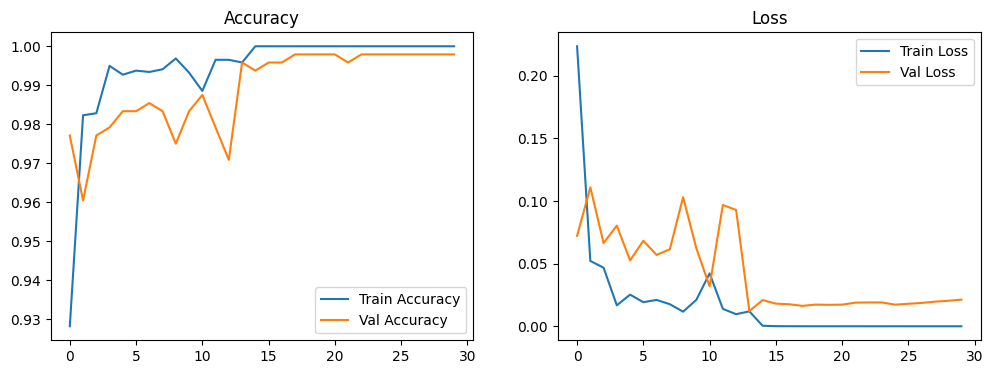

In [ ]:
# Plot training history
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'] + history_stage2.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'] + history_stage2.history['val_accuracy'], label='Val Accuracy')
plt.title('Accuracy')
plt.legend()
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'] + history_stage2.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'] + history_stage2.history['val_loss'], label='Val Loss')
plt.title('Loss')
plt.legend()
plt.show()

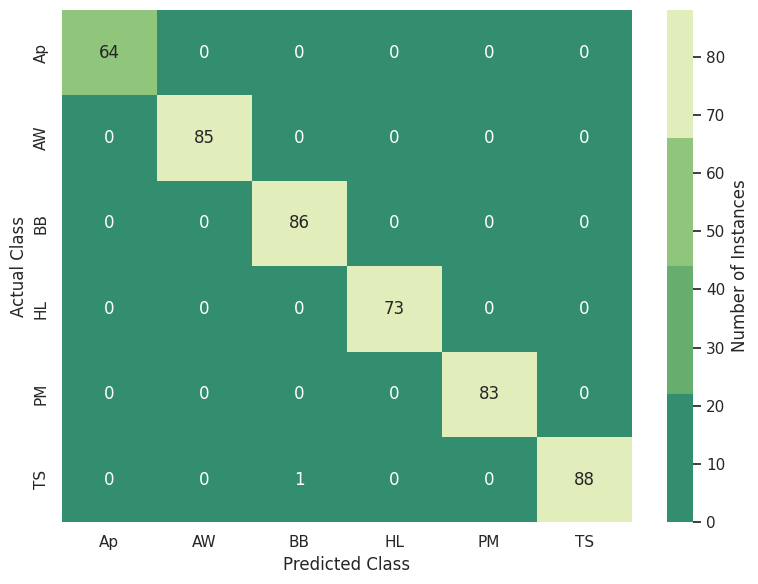

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib.colors import ListedColormap

# Define the confusion matrix
confusion_matrix = np.array([
    [64,  0,  0,  0,  0,  0],
 [ 0, 85,  0,  0,  0,  0],
 [ 0,  0, 86,  0,  0,  0],
 [ 0,  0,  0, 73,  0,  0],
 [ 0,  0,  0,  0, 83,  0],
 [ 0,  0,  1,  0,  0, 88],
])

# Define class names and their abbreviations
class_names = ['Aphids', 'Army worm', 'Bacterial Blight', 'Healthy', 'Powdery Mildew', 'Target spot']
class_abbr = ['Ap', 'AW', 'BB', 'HL', 'PM', 'TS']

# Define custom colors
colors = ['#328E6E', '#67AE6E', '#90C67C', '#E1EEBC']
custom_cmap = ListedColormap(colors)

# Set up the plot
plt.figure(figsize=(8, 6))
sns.set(font_scale=1)  # Increase font size for readability
sns.heatmap(confusion_matrix, annot=True, fmt='d', cmap=custom_cmap,
            xticklabels=class_abbr, yticklabels=class_abbr,
            cbar_kws={'label': 'Number of Instances'})
plt.xlabel('Predicted Class')
plt.ylabel('Actual Class')
# plt.title('Confusion Matrix for Cotton Leaf Disease Classification\n(ResNet50, Dual Augmentation, 40 layers, dropout=0.4)')
plt.tight_layout()

# Display the plot
plt.show()

# Save the figure
plt.savefig('confusion_matrix.png', dpi=300, bbox_inches='tight')
plt.close()

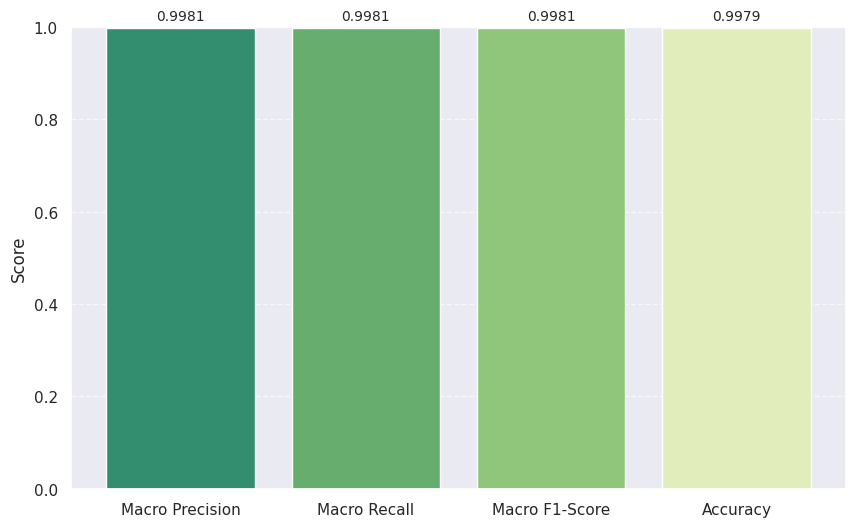

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

def calculate_metrics(confusion_matrix):
    n_classes = confusion_matrix.shape[0]

    # Initialize variables
    TP = np.zeros(n_classes)
    FP = np.zeros(n_classes)
    FN = np.zeros(n_classes)

    # Calculate TP, FP, FN for each class
    for i in range(n_classes):
        TP[i] = confusion_matrix[i, i]
        FP[i] = np.sum(confusion_matrix[:, i]) - TP[i]
        FN[i] = np.sum(confusion_matrix[i, :]) - TP[i]

    # Calculate macro-average precision, recall, f1-score
    precision = []
    recall = []
    for i in range(n_classes):
        prec = TP[i] / (TP[i] + FP[i]) if (TP[i] + FP[i]) > 0 else 0.0
        rec = TP[i] / (TP[i] + FN[i]) if (TP[i] + FN[i]) > 0 else 0.0
        precision.append(prec)
        recall.append(rec)

    macro_precision = np.mean(precision)
    macro_recall = np.mean(recall)
    macro_f1 = 2 * (macro_precision * macro_recall) / (macro_precision + macro_recall) if (macro_precision + macro_recall) > 0 else 0.0

    # Calculate overall accuracy
    total_correct = np.sum(TP)
    total_samples = np.sum(confusion_matrix)
    accuracy = total_correct / total_samples if total_samples > 0 else 0.0

    return macro_precision, macro_recall, macro_f1, accuracy

# Provided confusion matrix
confusion_matrix = np.array([
  [64,  0,  0,  0,  0,  0],
 [ 0, 85,  0,  0,  0,  0],
 [ 0,  0, 86,  0,  0,  0],
 [ 0,  0,  0, 73,  0,  0],
 [ 0,  0,  0,  0, 83,  0],
 [ 0,  0,  1,  0,  0, 88],
])

# Calculate metrics
macro_precision, macro_recall, macro_f1, accuracy = calculate_metrics(confusion_matrix)

# Create bar chart
metrics = ['Macro Precision', 'Macro Recall', 'Macro F1-Score', 'Accuracy']
values = [macro_precision, macro_recall, macro_f1, accuracy]

plt.figure(figsize=(10, 6))
bars = plt.bar(metrics, values, color=['#328E6E', '#67AE6E', '#90C67C', '#E1EEBC'])
plt.ylim(0, 1)
# plt.title('Evaluation Metrics [RandZCRandFR_CI_FT40] from Confusion Matrix', fontsize=13)
plt.ylabel('Score', fontsize=12)
plt.grid(axis='y', linestyle='--', alpha=0.7)

# Add value labels on top of bars
for bar in bars:
    yval = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2, yval + 0.01, f'{yval:.4f}',
             ha='center', va='bottom', fontsize=10)

# plt.savefig('FT40_ResNet50_evaluation_metrics[RandZCRandFR_CI].png')